In [13]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import warnings
warnings.filterwarnings('ignore')

In [16]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [49]:
import numpy as np
import os

node_num = 16
training_id = 0
check_point = 250
end_point = 280

folder_path = os.path.join(os.getcwd(), '../learn_output')
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))

weight = np.load(file_path, allow_pickle=True)

x_train = weight[:-1,:]
y_train = weight[1:,:]

for training_id in range(1, check_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_train = np.concatenate((x_train, weight[:-1,:]), axis = 0)
    y_train = np.concatenate((y_train, weight[1:,:]), axis = 0)

training_id = check_point
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
weight = np.load(file_path, allow_pickle=True)

x_test = weight[:-1,:]
y_test = weight[1:,:]

for training_id in range(check_point, end_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_test = np.concatenate((x_test, weight[:-1,:]), axis = 0)
    y_test = np.concatenate((y_test, weight[1:,:]), axis = 0)


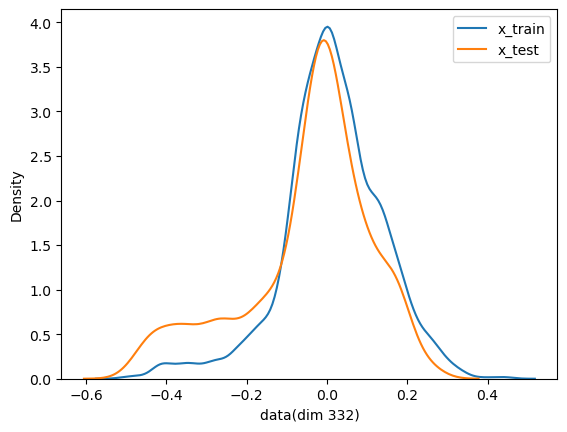

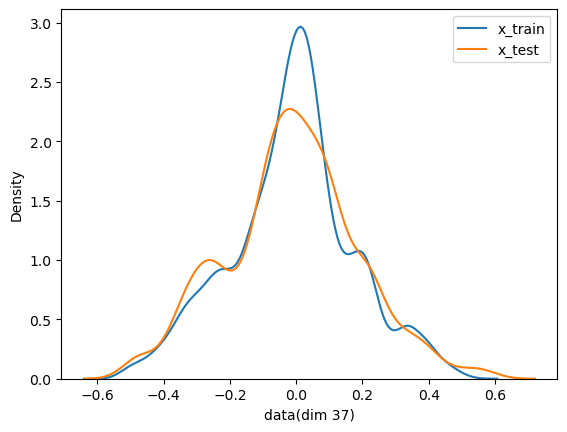

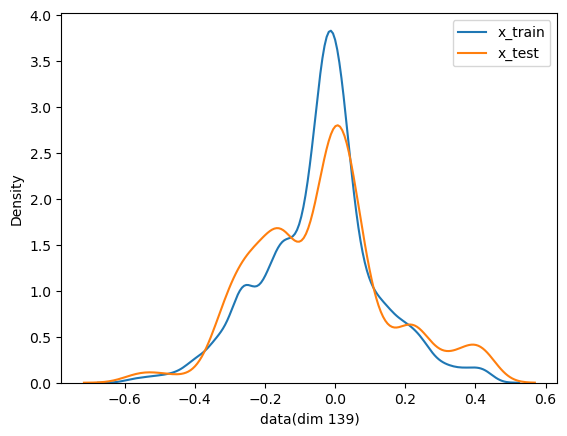

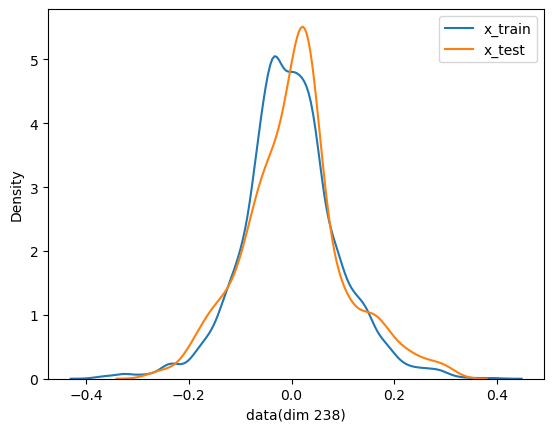

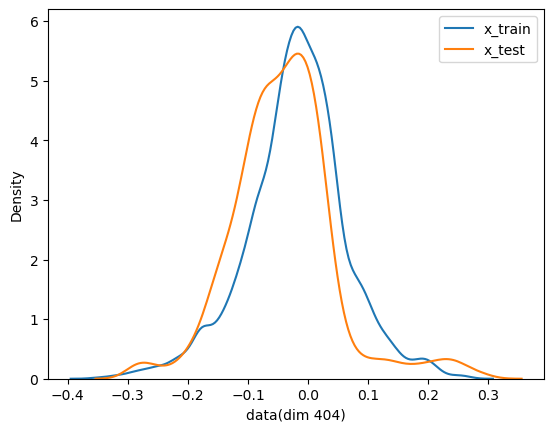

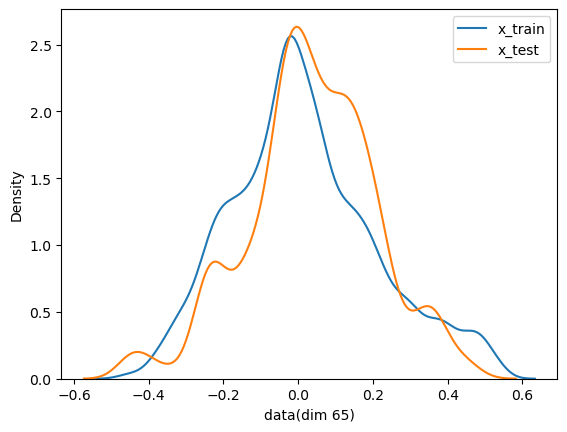

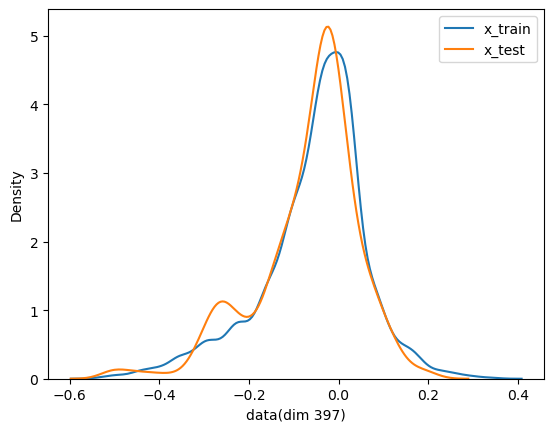

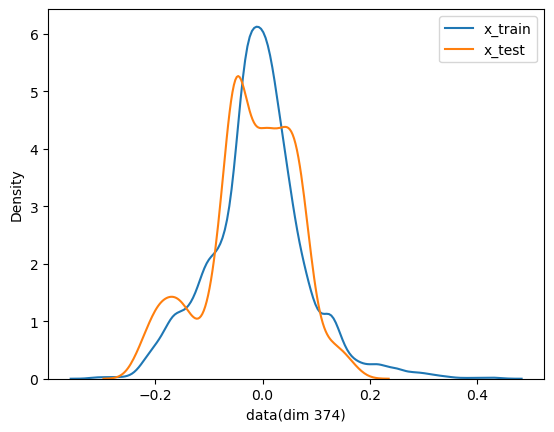

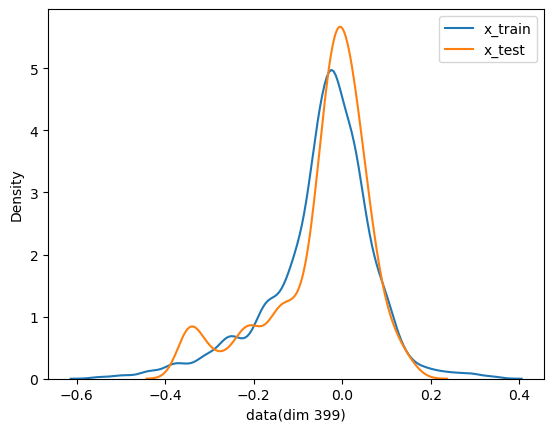

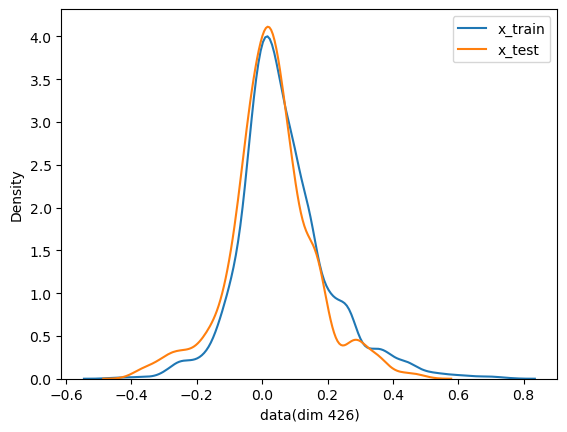

[332, 37, 139, 238, 404, 65, 397, 374, 399, 426]


In [118]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train[:, random_number], label = 'x_train')
    sns.kdeplot(x_test[:, random_number], label = 'x_test')
    plt.xlabel('data(dim %d)' % random_number)
    plt.legend()
    plt.show()

#     indices = np.unravel_index(range(len(x_train[:, random_number])), x_train[:, random_number].shape)
    
#     density = plt.hist2d(x_train[:, random_number], y_train[:, random_number], bins=len(x_train[:, random_number]), cmap='Blues')[0]
#     colors = density[indices]
#     alphas = density.flatten() / density.max()

#     plt.scatter(x_train[:, random_number], y_train[:, random_number], cmap='Blues', alpha=0.1)


print(random_numbers)

In [51]:
permuted_indices = np.random.permutation(x_train.shape[0])
x_train = x_train[permuted_indices, :]
y_train = y_train[permuted_indices, :]


In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
y_train_scaled = scaler.transform(y_train)
x_test_scaled = scaler.transform(x_test)
y_test_scaled = scaler.transform(y_test)

In [58]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, layer_sizes=[128,128], n_psi_train=64, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [
            Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d' % i)
            for i in range(len(layer_sizes))
        ]
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config
    
class PsiNN(Layer):
    """Concatenate constant, data and trainable dictionaries together as [1, data, DicNN]

    """
    
    def __init__(
        self,
        dic_trainable = DicNN,
        layer_sizes=[64,64],
        n_psi_train=22,
        **kwargs):
        super(PsiNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.dic_trainable = dic_trainable
        self.n_dic_customized = n_psi_train
        self.dicNN = self.dic_trainable(
            layer_sizes=self.layer_sizes,
            n_psi_train=self.n_dic_customized)
    
    def call(self, inputs):
        constant = tf.ones_like(tf.slice(inputs, [0, 0], [-1, 1]))
        psi_x_train = self.dicNN(inputs)
        outputs = Concatenate()([constant, inputs, psi_x_train])
        return outputs
    
    def generate_B(self, inputs):
        target_dim = inputs.shape[-1]
        self.basis_func_number = self.n_dic_customized + target_dim + 1
        # Form B matrix
        self.B = np.zeros((self.basis_func_number, target_dim))
        for i in range(0, target_dim):
            self.B[i + 1][i] = 1
        return self.B

    def get_config(self):
        config = super(PsiNN, self).get_config()
        config.update({
            'dic_trainable': self.dic_trainable,
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_dic_customized
        })
        return config

In [59]:
dic = PsiNN(n_psi_train = 2000)
inputs_x = Input((np.shape(x_train)[1],))
model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x))

In [60]:
model_psi.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 466)]        0           []                               
                                                                                                  
 tf.slice_4 (TFOpLambda)        (None, 1)            0           ['input_15[0][0]']               
                                                                                                  
 tf.ones_like_4 (TFOpLambda)    (None, 1)            0           ['tf.slice_4[0][0]']             
                                                                                                  
 dic_nn_4 (DicNN)               (None, 2000)         168144      ['input_15[0][0]']               
                                                                                            

In [61]:
inputs_x = Input((np.shape(x_train)[1],))
inputs_y = Input((np.shape(y_train)[1],))
psi_x = model_psi(inputs_x)
psi_y = model_psi(inputs_y)
k_layer = Dense(units = 1 + np.shape(x_train)[1] + dic.n_dic_customized, use_bias=False, name = 'k_layer')
outputs_x = k_layer(psi_x)
outputs = outputs_x - psi_y
model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs)

In [62]:
import tensorflow.keras.backend as K
batch_size = 4096

model_koopman.compile(optimizer='adam', loss='mse')

import tensorflow.keras.backend as K

lbd = 0.000001
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_true - y_pred))  # MSE loss
    l2_loss = K.sqrt(K.sum(K.square(model_koopman.get_layer('k_layer').weights[0])))
    total_loss = mse_loss + lbd * l2_loss  # Total loss, where lbd is the regularization weight
    return total_loss

model_koopman.compile(optimizer='adam', loss=custom_loss)

from tensorflow.keras.callbacks import TensorBoard

class LossHistoryCallback(TensorBoard):
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)
    
    def on_epoch_end(self, epoch, logs=None):
        l2_loss = lbd * K.sqrt(K.sum(K.square(model_koopman.get_layer('k_layer').weights[0])))
        mse_loss = logs['loss']-l2_loss  # MSE loss
        logs.update({'mse_loss': mse_loss, 'l2_loss': l2_loss})
        super().on_epoch_end(epoch, logs)

log_dir = "logs_0712_PsiNN/"

tensorboard_callback = LossHistoryCallback(log_dir=log_dir, histogram_freq=1)

history = model_koopman.fit(
    [x_train, y_train],
    tf.zeros_like(model_psi(x_train)),
    validation_data=(
        [x_test, y_test],
        tf.zeros_like(model_psi(x_test))
    ),
    verbose=2,
    epochs=500,
    batch_size=batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/500
3/3 - 1s - loss: 0.0355 - val_loss: 0.0219 - mse_loss: 0.0355 - l2_loss: 4.9514e-05 - 1s/epoch - 471ms/step
Epoch 2/500
3/3 - 1s - loss: 0.0170 - val_loss: 0.0163 - mse_loss: 0.0169 - l2_loss: 4.9489e-05 - 557ms/epoch - 186ms/step
Epoch 3/500
3/3 - 1s - loss: 0.0125 - val_loss: 0.0140 - mse_loss: 0.0125 - l2_loss: 4.9503e-05 - 563ms/epoch - 188ms/step
Epoch 4/500
3/3 - 1s - loss: 0.0100 - val_loss: 0.0121 - mse_loss: 0.0100 - l2_loss: 4.9509e-05 - 561ms/epoch - 187ms/step
Epoch 5/500
3/3 - 1s - loss: 0.0081 - val_loss: 0.0106 - mse_loss: 0.0081 - l2_loss: 4.9498e-05 - 551ms/epoch - 184ms/step
Epoch 6/500
3/3 - 1s - loss: 0.0066 - val_loss: 0.0094 - mse_loss: 0.0066 - l2_loss: 4.9477e-05 - 560ms/epoch - 187ms/step
Epoch 7/500
3/3 - 1s - loss: 0.0055 - val_loss: 0.0085 - mse_loss: 0.0054 - l2_loss: 4.9451e-05 - 551ms/epoch - 184ms/step
Epoch 8/500
3/3 - 1s - loss: 0.0046 - val_loss: 0.0078 - mse_loss: 0.0046 - l2_loss: 4.9427e-05 - 552ms/epoch - 184ms/step
Epoch 9/500
3/3 - 1

Epoch 65/500
3/3 - 1s - loss: 3.8591e-04 - val_loss: 0.0023 - mse_loss: 3.3657e-04 - l2_loss: 4.9346e-05 - 550ms/epoch - 183ms/step
Epoch 66/500
3/3 - 1s - loss: 3.8022e-04 - val_loss: 0.0023 - mse_loss: 3.3087e-04 - l2_loss: 4.9346e-05 - 560ms/epoch - 187ms/step
Epoch 67/500
3/3 - 1s - loss: 3.7475e-04 - val_loss: 0.0023 - mse_loss: 3.2541e-04 - l2_loss: 4.9346e-05 - 577ms/epoch - 192ms/step
Epoch 68/500
3/3 - 1s - loss: 3.6943e-04 - val_loss: 0.0023 - mse_loss: 3.2008e-04 - l2_loss: 4.9347e-05 - 578ms/epoch - 193ms/step
Epoch 69/500
3/3 - 1s - loss: 3.6432e-04 - val_loss: 0.0023 - mse_loss: 3.1498e-04 - l2_loss: 4.9347e-05 - 561ms/epoch - 187ms/step
Epoch 70/500
3/3 - 1s - loss: 3.5933e-04 - val_loss: 0.0023 - mse_loss: 3.0998e-04 - l2_loss: 4.9347e-05 - 563ms/epoch - 188ms/step
Epoch 71/500
3/3 - 1s - loss: 3.5450e-04 - val_loss: 0.0023 - mse_loss: 3.0515e-04 - l2_loss: 4.9347e-05 - 567ms/epoch - 189ms/step
Epoch 72/500
3/3 - 1s - loss: 3.4980e-04 - val_loss: 0.0022 - mse_loss: 3.00

Epoch 127/500
3/3 - 1s - loss: 2.1269e-04 - val_loss: 0.0017 - mse_loss: 1.6339e-04 - l2_loss: 4.9294e-05 - 579ms/epoch - 193ms/step
Epoch 128/500
3/3 - 1s - loss: 2.1136e-04 - val_loss: 0.0017 - mse_loss: 1.6207e-04 - l2_loss: 4.9292e-05 - 559ms/epoch - 186ms/step
Epoch 129/500
3/3 - 1s - loss: 2.1006e-04 - val_loss: 0.0017 - mse_loss: 1.6077e-04 - l2_loss: 4.9290e-05 - 554ms/epoch - 185ms/step
Epoch 130/500
3/3 - 1s - loss: 2.0877e-04 - val_loss: 0.0017 - mse_loss: 1.5948e-04 - l2_loss: 4.9288e-05 - 551ms/epoch - 184ms/step
Epoch 131/500
3/3 - 1s - loss: 2.0753e-04 - val_loss: 0.0017 - mse_loss: 1.5824e-04 - l2_loss: 4.9286e-05 - 554ms/epoch - 185ms/step
Epoch 132/500
3/3 - 1s - loss: 2.0627e-04 - val_loss: 0.0017 - mse_loss: 1.5698e-04 - l2_loss: 4.9284e-05 - 558ms/epoch - 186ms/step
Epoch 133/500
3/3 - 1s - loss: 2.0504e-04 - val_loss: 0.0017 - mse_loss: 1.5576e-04 - l2_loss: 4.9282e-05 - 556ms/epoch - 185ms/step
Epoch 134/500
3/3 - 1s - loss: 2.0382e-04 - val_loss: 0.0017 - mse_lo

Epoch 189/500
3/3 - 1s - loss: 1.5814e-04 - val_loss: 0.0014 - mse_loss: 1.0904e-04 - l2_loss: 4.9109e-05 - 551ms/epoch - 184ms/step
Epoch 190/500
3/3 - 1s - loss: 1.5758e-04 - val_loss: 0.0014 - mse_loss: 1.0847e-04 - l2_loss: 4.9105e-05 - 550ms/epoch - 183ms/step
Epoch 191/500
3/3 - 1s - loss: 1.5700e-04 - val_loss: 0.0014 - mse_loss: 1.0790e-04 - l2_loss: 4.9101e-05 - 546ms/epoch - 182ms/step
Epoch 192/500
3/3 - 1s - loss: 1.5643e-04 - val_loss: 0.0014 - mse_loss: 1.0733e-04 - l2_loss: 4.9097e-05 - 558ms/epoch - 186ms/step
Epoch 193/500
3/3 - 1s - loss: 1.5588e-04 - val_loss: 0.0014 - mse_loss: 1.0678e-04 - l2_loss: 4.9093e-05 - 545ms/epoch - 182ms/step
Epoch 194/500
3/3 - 1s - loss: 1.5533e-04 - val_loss: 0.0014 - mse_loss: 1.0624e-04 - l2_loss: 4.9089e-05 - 565ms/epoch - 188ms/step
Epoch 195/500
3/3 - 1s - loss: 1.5477e-04 - val_loss: 0.0014 - mse_loss: 1.0569e-04 - l2_loss: 4.9085e-05 - 566ms/epoch - 189ms/step
Epoch 196/500
3/3 - 1s - loss: 1.5424e-04 - val_loss: 0.0014 - mse_lo

Epoch 251/500
3/3 - 1s - loss: 1.3118e-04 - val_loss: 0.0012 - mse_loss: 8.2356e-05 - l2_loss: 4.8824e-05 - 557ms/epoch - 186ms/step
Epoch 252/500
3/3 - 1s - loss: 1.3086e-04 - val_loss: 0.0012 - mse_loss: 8.2038e-05 - l2_loss: 4.8818e-05 - 590ms/epoch - 197ms/step
Epoch 253/500
3/3 - 1s - loss: 1.3053e-04 - val_loss: 0.0012 - mse_loss: 8.1721e-05 - l2_loss: 4.8813e-05 - 552ms/epoch - 184ms/step
Epoch 254/500
3/3 - 1s - loss: 1.3021e-04 - val_loss: 0.0012 - mse_loss: 8.1404e-05 - l2_loss: 4.8808e-05 - 564ms/epoch - 188ms/step
Epoch 255/500
3/3 - 1s - loss: 1.2990e-04 - val_loss: 0.0012 - mse_loss: 8.1093e-05 - l2_loss: 4.8803e-05 - 565ms/epoch - 188ms/step
Epoch 256/500
3/3 - 1s - loss: 1.2957e-04 - val_loss: 0.0012 - mse_loss: 8.0778e-05 - l2_loss: 4.8797e-05 - 553ms/epoch - 184ms/step
Epoch 257/500
3/3 - 1s - loss: 1.2926e-04 - val_loss: 0.0012 - mse_loss: 8.0471e-05 - l2_loss: 4.8792e-05 - 574ms/epoch - 191ms/step
Epoch 258/500
3/3 - 1s - loss: 1.2895e-04 - val_loss: 0.0012 - mse_lo

Epoch 313/500
3/3 - 1s - loss: 1.1477e-04 - val_loss: 0.0011 - mse_loss: 6.6307e-05 - l2_loss: 4.8464e-05 - 573ms/epoch - 191ms/step
Epoch 314/500
3/3 - 1s - loss: 1.1456e-04 - val_loss: 0.0011 - mse_loss: 6.6099e-05 - l2_loss: 4.8458e-05 - 555ms/epoch - 185ms/step
Epoch 315/500
3/3 - 1s - loss: 1.1435e-04 - val_loss: 0.0010 - mse_loss: 6.5895e-05 - l2_loss: 4.8452e-05 - 554ms/epoch - 185ms/step
Epoch 316/500
3/3 - 1s - loss: 1.1414e-04 - val_loss: 0.0010 - mse_loss: 6.5694e-05 - l2_loss: 4.8445e-05 - 553ms/epoch - 184ms/step
Epoch 317/500
3/3 - 1s - loss: 1.1393e-04 - val_loss: 0.0010 - mse_loss: 6.5490e-05 - l2_loss: 4.8439e-05 - 583ms/epoch - 194ms/step
Epoch 318/500
3/3 - 1s - loss: 1.1371e-04 - val_loss: 0.0010 - mse_loss: 6.5282e-05 - l2_loss: 4.8432e-05 - 549ms/epoch - 183ms/step
Epoch 319/500
3/3 - 1s - loss: 1.1351e-04 - val_loss: 0.0010 - mse_loss: 6.5083e-05 - l2_loss: 4.8426e-05 - 558ms/epoch - 186ms/step
Epoch 320/500
3/3 - 1s - loss: 1.1330e-04 - val_loss: 0.0010 - mse_lo

Epoch 374/500
3/3 - 1s - loss: 1.0367e-04 - val_loss: 9.3859e-04 - mse_loss: 5.5622e-05 - l2_loss: 4.8051e-05 - 558ms/epoch - 186ms/step
Epoch 375/500
3/3 - 1s - loss: 1.0351e-04 - val_loss: 9.3695e-04 - mse_loss: 5.5468e-05 - l2_loss: 4.8044e-05 - 553ms/epoch - 184ms/step
Epoch 376/500
3/3 - 1s - loss: 1.0336e-04 - val_loss: 9.3542e-04 - mse_loss: 5.5328e-05 - l2_loss: 4.8037e-05 - 559ms/epoch - 186ms/step
Epoch 377/500
3/3 - 1s - loss: 1.0322e-04 - val_loss: 9.3375e-04 - mse_loss: 5.5192e-05 - l2_loss: 4.8029e-05 - 561ms/epoch - 187ms/step
Epoch 378/500
3/3 - 1s - loss: 1.0305e-04 - val_loss: 9.3184e-04 - mse_loss: 5.5032e-05 - l2_loss: 4.8022e-05 - 551ms/epoch - 184ms/step
Epoch 379/500
3/3 - 1s - loss: 1.0290e-04 - val_loss: 9.3024e-04 - mse_loss: 5.4889e-05 - l2_loss: 4.8015e-05 - 563ms/epoch - 188ms/step
Epoch 380/500
3/3 - 1s - loss: 1.0276e-04 - val_loss: 9.2848e-04 - mse_loss: 5.4749e-05 - l2_loss: 4.8008e-05 - 552ms/epoch - 184ms/step
Epoch 381/500
3/3 - 1s - loss: 1.0260e-04

Epoch 434/500
3/3 - 1s - loss: 9.5532e-05 - val_loss: 8.4456e-04 - mse_loss: 4.7937e-05 - l2_loss: 4.7595e-05 - 553ms/epoch - 184ms/step
Epoch 435/500
3/3 - 1s - loss: 9.5412e-05 - val_loss: 8.4275e-04 - mse_loss: 4.7825e-05 - l2_loss: 4.7587e-05 - 543ms/epoch - 181ms/step
Epoch 436/500
3/3 - 1s - loss: 9.5298e-05 - val_loss: 8.4150e-04 - mse_loss: 4.7718e-05 - l2_loss: 4.7579e-05 - 556ms/epoch - 185ms/step
Epoch 437/500
3/3 - 1s - loss: 9.5175e-05 - val_loss: 8.3993e-04 - mse_loss: 4.7604e-05 - l2_loss: 4.7571e-05 - 590ms/epoch - 197ms/step
Epoch 438/500
3/3 - 1s - loss: 9.5056e-05 - val_loss: 8.3866e-04 - mse_loss: 4.7493e-05 - l2_loss: 4.7563e-05 - 556ms/epoch - 185ms/step
Epoch 439/500
3/3 - 1s - loss: 9.4939e-05 - val_loss: 8.3720e-04 - mse_loss: 4.7384e-05 - l2_loss: 4.7555e-05 - 557ms/epoch - 186ms/step
Epoch 440/500
3/3 - 1s - loss: 9.4821e-05 - val_loss: 8.3558e-04 - mse_loss: 4.7274e-05 - l2_loss: 4.7547e-05 - 554ms/epoch - 185ms/step
Epoch 441/500
3/3 - 1s - loss: 9.4712e-05

Epoch 494/500
3/3 - 1s - loss: 8.9134e-05 - val_loss: 7.6346e-04 - mse_loss: 4.2038e-05 - l2_loss: 4.7096e-05 - 580ms/epoch - 193ms/step
Epoch 495/500
3/3 - 1s - loss: 8.9037e-05 - val_loss: 7.6224e-04 - mse_loss: 4.1951e-05 - l2_loss: 4.7087e-05 - 554ms/epoch - 185ms/step
Epoch 496/500
3/3 - 1s - loss: 8.8945e-05 - val_loss: 7.6086e-04 - mse_loss: 4.1867e-05 - l2_loss: 4.7078e-05 - 548ms/epoch - 183ms/step
Epoch 497/500
3/3 - 1s - loss: 8.8849e-05 - val_loss: 7.5983e-04 - mse_loss: 4.1780e-05 - l2_loss: 4.7070e-05 - 555ms/epoch - 185ms/step
Epoch 498/500
3/3 - 1s - loss: 8.8756e-05 - val_loss: 7.5853e-04 - mse_loss: 4.1696e-05 - l2_loss: 4.7061e-05 - 545ms/epoch - 182ms/step
Epoch 499/500
3/3 - 1s - loss: 8.8659e-05 - val_loss: 7.5726e-04 - mse_loss: 4.1607e-05 - l2_loss: 4.7052e-05 - 551ms/epoch - 184ms/step
Epoch 500/500
3/3 - 1s - loss: 8.8571e-05 - val_loss: 7.5578e-04 - mse_loss: 4.1528e-05 - l2_loss: 4.7043e-05 - 550ms/epoch - 183ms/step


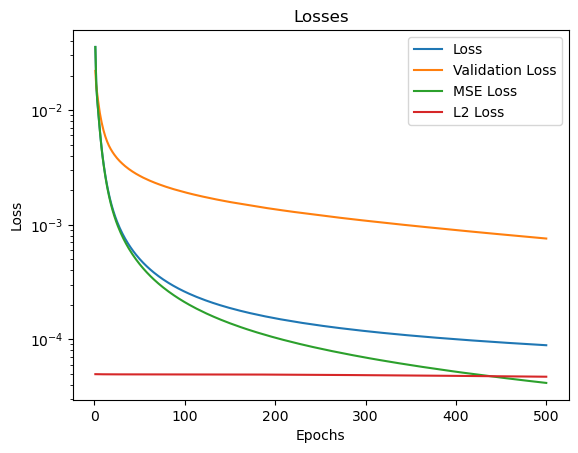

In [65]:
import matplotlib.pyplot as plt

mse_loss = history.history['mse_loss']
l2_loss = history.history['l2_loss']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mse_loss) + 1)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, mse_loss, label='MSE Loss')
plt.plot(epochs, l2_loss, label='L2 Loss')


plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.show()


In [119]:
model_path = 'model_koopman_8.h5'
model_koopman.save_weights(model_path)

In [66]:
k_layer = model_koopman.get_layer('k_layer')
matrix = k_layer.trainable_variables[0]
eigenvalues, eigenvectors = tf.linalg.eig(matrix)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# Extract real and imaginary parts
real_part = np.real(eigenvalues)
imag_part = np.imag(eigenvalues)

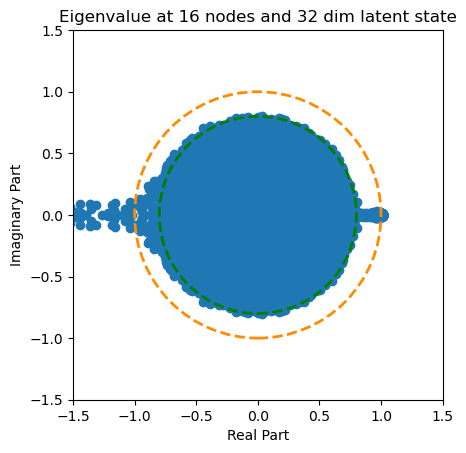

In [67]:
fig, ax = plt.subplots()
ax.scatter(real_part, imag_part)

# Label the axes
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')

# Label the caption
plt.title('Eigenvalue at %d nodes and 32 dim latent state' % node_num)

# Add the unit circle
unit_circle = Circle((0, 0), radius=1, fill=False, linestyle='--', linewidth=2, color = 'darkorange')
half_circle = Circle((0, 0), radius=0.8, fill=False, linestyle='--', linewidth=2, color = 'green')

ax.add_artist(unit_circle)
ax.add_artist(half_circle)


# Set the axis limits to show the full circle
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_aspect('equal')


# Show the plot
plt.show()


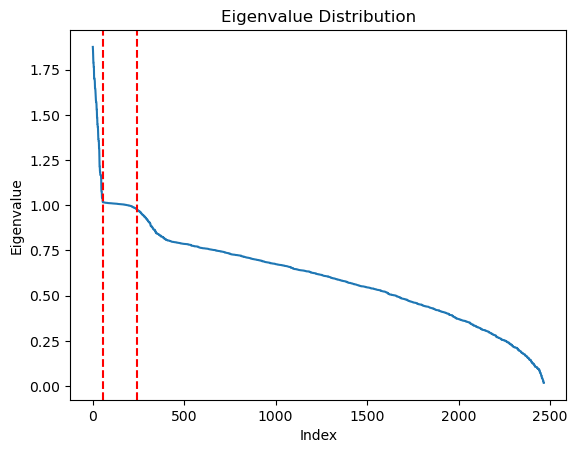

In [84]:
import matplotlib.pyplot as plt
sorted_eigenvalues = np.sort(np.abs(eigenvalues))[::-1]

# 绘制特征值的分布图
plt.plot(sorted_eigenvalues)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Distribution')

low_index = 0
high_index = 0
for eigenvalue in sorted_eigenvalues:
    if eigenvalue > 1.02:
        low_index += 1
    if eigenvalue > 0.98:
        high_index += 1 
        

plt.axvline(low_index, color='r', linestyle='--', label='xxx')
plt.axvline(high_index, color='r', linestyle='--', label='xxx')


plt.show()

In [85]:
high_index - low_index

184

In [86]:
eigenvectors

<tf.Tensor: shape=(2467, 2467), dtype=complex64, numpy=
array([[-0.01622471+0.j        , -0.01278611+0.j        ,
         0.00178388+0.j        , ..., -0.00766176+0.00645428j,
        -0.00766176-0.00645428j,  0.00591052+0.j        ],
       [-0.03476352+0.j        ,  0.03682418+0.j        ,
         0.07842163+0.j        , ..., -0.00119077+0.00313724j,
        -0.00119077-0.00313724j, -0.00222361+0.j        ],
       [-0.06080536+0.j        , -0.00191449+0.j        ,
         0.06794127+0.j        , ..., -0.00620217-0.00130385j,
        -0.00620217+0.00130385j,  0.00776406+0.j        ],
       ...,
       [-0.01772135+0.j        , -0.02478922+0.j        ,
        -0.00318777+0.j        , ...,  0.01194989+0.00385884j,
         0.01194989-0.00385884j, -0.00618944+0.j        ],
       [-0.01433284+0.j        , -0.01306388+0.j        ,
        -0.0173103 +0.j        , ..., -0.01651645+0.00493236j,
        -0.01651645-0.00493236j,  0.01255853+0.j        ],
       [ 0.01107326+0.j        ,

In [90]:
eigenvectors1 = []
eigenvectors2 = []

for i, eigenvalue in enumerate(eigenvalues):
    if np.abs(eigenvalue) > 1.02:
        eigenvectors1.append(eigenvectors[:,i])
    else:
        if np.abs(eigenvalue) > 0.98:
            eigenvectors2.append(eigenvectors[:,i])

In [99]:
eigenvectors1

[<tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([-0.01622471+0.j, -0.03476352+0.j, -0.06080536+0.j, ...,
        -0.01772135+0.j, -0.01433284+0.j,  0.01107326+0.j], dtype=complex64)>,
 <tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([-0.01278611+0.j,  0.03682418+0.j, -0.00191449+0.j, ...,
        -0.02478922+0.j, -0.01306388+0.j, -0.00349311+0.j], dtype=complex64)>,
 <tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([ 0.00178388+0.j,  0.07842163+0.j,  0.06794127+0.j, ...,
        -0.00318777+0.j, -0.0173103 +0.j, -0.03840454+0.j], dtype=complex64)>,
 <tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([ 0.00323139+0.00877748j, -0.00108851-0.01160837j,
        -0.01126483-0.02346595j, ..., -0.01413989-0.00187649j,
         0.00576226-0.01099452j, -0.00783509+0.00401028j], dtype=complex64)>,
 <tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([ 0.00323139-0.00877748j, -0.00108851+0.01160837j,
        -0.01126483+0.02346595j, ..., -0.01413989+0.00

In [98]:
eigenvectors2

[<tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([ 0.00820503-0.01664313j, -0.02344102-0.00047945j,
         0.00831244-0.01416304j, ..., -0.00386453-0.00242218j,
         0.00222169+0.02055419j,  0.00517377+0.0036237j ], dtype=complex64)>,
 <tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([ 0.00820503+0.01664313j, -0.02344102+0.00047945j,
         0.00831244+0.01416304j, ..., -0.00386453+0.00242218j,
         0.00222169-0.02055419j,  0.00517377-0.0036237j ], dtype=complex64)>,
 <tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([-0.00385887-0.00156504j, -0.01359854-0.01266228j,
        -0.03356997+0.0125925j , ...,  0.02894573+0.01713784j,
         0.02072404+0.00704261j, -0.01522307+0.00631298j], dtype=complex64)>,
 <tf.Tensor: shape=(2467,), dtype=complex64, numpy=
 array([-0.00385887+0.00156504j, -0.01359854+0.01266228j,
        -0.03356997-0.0125925j , ...,  0.02894573-0.01713784j,
         0.02072404-0.00704261j, -0.01522307-0.00631298j], dtype=complex64

In [113]:
import numpy as np
from scipy.spatial import distance

def calculate_similarity(vector1, vector2):
    cosine_sim = 1 - np.abs(1 - distance.cosine(vector1, vector2))
    return cosine_sim

In [114]:
num_vectors = len(eigenvectors1)
similarities = np.zeros((num_vectors, num_vectors))

for i in range(num_vectors):
    for j in range(num_vectors):
        vector1 = eigenvectors1[i]
        vector2 = eigenvectors1[j]
        similarities[i][j] = calculate_similarity(vector1, vector2)

print(similarities)

[[5.96046448e-08 2.34039545e-01 7.15774149e-01 ... 9.97506390e-01
  9.97506390e-01 9.77540072e-01]
 [2.34039545e-01 0.00000000e+00 7.61534244e-01 ... 9.59821749e-01
  9.59821749e-01 9.25694987e-01]
 [7.15774149e-01 7.61534244e-01 0.00000000e+00 ... 9.57326655e-01
  9.57326655e-01 9.25687112e-01]
 ...
 [9.97506390e-01 9.59821749e-01 9.57326655e-01 ... 0.00000000e+00
  1.67652845e-01 8.94762571e-01]
 [9.97506390e-01 9.59821749e-01 9.57326655e-01 ... 1.67652845e-01
  0.00000000e+00 8.94762571e-01]
 [9.77540072e-01 9.25694987e-01 9.25687112e-01 ... 8.94762571e-01
  8.94762571e-01 0.00000000e+00]]


In [115]:
num_vectors2 = len(eigenvectors2)
similarities2 = np.zeros((num_vectors2, num_vectors2))

for i in range(num_vectors2):
    for j in range(num_vectors2):
        vector1 = eigenvectors2[i]
        vector2 = eigenvectors2[j]
        similarities2[i][j] = calculate_similarity(vector1, vector2)

print(similarities2)

[[0.00000000e+00 0.00000000e+00 9.73084503e-01 ... 9.50511622e-01
  9.75554934e-01 9.74724246e-01]
 [0.00000000e+00 0.00000000e+00 9.88669630e-01 ... 9.75554934e-01
  9.50511622e-01 9.74724246e-01]
 [9.73084503e-01 9.88669630e-01 0.00000000e+00 ... 6.47517754e-01
  6.22219754e-01 8.00615870e-01]
 ...
 [9.50511622e-01 9.75554934e-01 6.47517754e-01 ... 0.00000000e+00
  0.00000000e+00 5.31292572e-01]
 [9.75554934e-01 9.50511622e-01 6.22219754e-01 ... 0.00000000e+00
  0.00000000e+00 5.31292572e-01]
 [9.74724246e-01 9.74724246e-01 8.00615870e-01 ... 5.31292572e-01
  5.31292572e-01 5.96046448e-08]]


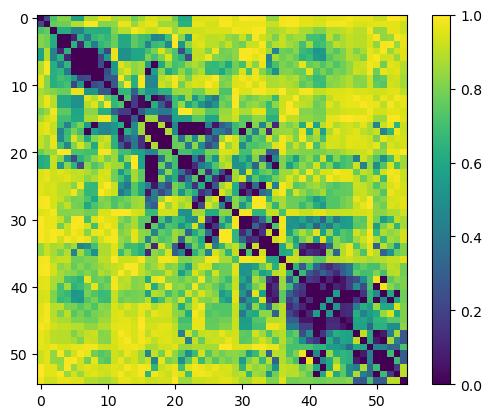

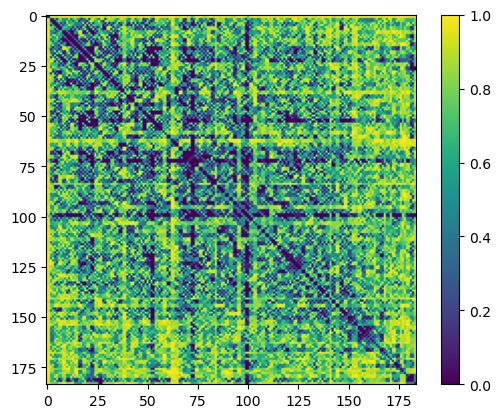

In [117]:
plt.imshow(similarities, vmin=0, vmax=1)
plt.colorbar()
plt.show()

plt.imshow(similarities2, vmin=0, vmax=1)
plt.colorbar()
plt.show()